# Сборный Проект — 2. HR-аналитика

## Описание проекта
**Цель:**

Разработать решение, которое поможет HR-аналитикам компании «Работа с заботой» прогнозировать уровень удовлетворённости сотрудников и вероятность их увольнения, чтобы снизить кадровые риски и финансовые потери компании.

**Задачи:**

*   Построить модель, которая предсказывает уровень удовлетворённости сотрудника работой на основе характеристик сотрудника;
*   Использовать полученные результаты для построения второй модели — предсказания увольнения, определяющей вероятность того, что сотрудник покинет компанию;
*   Проверить, как уровень удовлетворённости влияет на увольнение, и добавить этот показатель как дополнительный признак во вторую модель;
*   Сравнить качество моделей и определить, какие признаки наиболее влияют на удовлетворённость и увольнение сотрудников.

**Подход:**

*   Использовать данные о сотрудниках компании: отдел, уровень должности, стаж, нагрузку, факт повышения, наличие нарушений, оценку руководителя и уровень зарплаты;
*   Для первой задачи (регрессии) — применить линейную модель и дерево решений, оценив качество по метрике SMAPE;
*   Для второй задачи (классификации) — обучить минимум три модели и оценить их по метрике ROC-AUC;
*   Проверить гипотезу о влиянии удовлетворённости на увольнение, визуализировать взаимосвязь и использовать предсказанные значения как дополнительный входной признак;

**План работы:**

1.   Первая задача:

      *   Загрузка данных;
      *   Предобработка данных;
      *   Исследовательский анализ данных;
      *   Подготовка признаков и построение пайплайнов;
      *   Обучение и настройка моделей;
      *   Оценка качества и сравнение результатов;

1.   Вторая задача:

      *   Загрузка данных;
      *   Предобработка данных;
      *   Исследовательский анализ данных;
      *   Добавление нового входного признака;
      *   Подготовка признаков и построение пайплайнов;
      *   Обучение и настройка моделей;
      *   Оценка качества и сравнение результатов;






In [1]:
# подключение google-диска
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install shap -q
import shap
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, KFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip install phik -q
from phik import resources, report
from phik.report import plot_correlation_matrix
!pip install -U scikit-learn -q
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from scipy.stats import ttest_ind

## Задача 1

### Загрузка данных

In [3]:
# загрузка данных
try:
    # задача 1
    train_1 = pd.read_csv('/content/drive/MyDrive/данные/train_job_satisfaction_rate.csv', decimal=".") # Тренировочная выборка
    test_features = pd.read_csv('/content/drive/MyDrive/данные/test_features.csv', decimal=".") # Входные признаки тестовой выборки
    test_rate = pd.read_csv('/content/drive/MyDrive/данные/test_target_job_satisfaction_rate.csv', decimal=".") # Целевой признак тестовой выборки
    # задача 2
    train_quit = pd.read_csv('/content/drive/MyDrive/данные/train_quit.csv', sep=",", decimal=".") # Тренировочная выборка
    test_quit = pd.read_csv('/content/drive/MyDrive/данные/test_target_quit.csv', sep=",", decimal=".") # Целевой признак тестовой выборки
except:
    # задача 1
    train_1 = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', decimal=".") # Тренировочная выборка
    test_features = pd.read_csv('/datasets/test_features.csv', decimal=".") # Входные признаки тестовой выборки
    test_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', decimal=".") # Целевой признак тестовой выборки
    # задача 2
    train_quit = pd.read_csv('/datasets/train_quit.csv', sep=",", decimal=".") # Тренировочная выборка
    test_quit = pd.read_csv('/datasets/test_target_quit.csv', sep=",", decimal=".") # Целевой признак тестовой выборки

In [4]:
train_1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


**id** -	уникальный идентификатор сотрудника;

**dept** -	отдел, в котором работает сотрудник;

**level**	- уровень занимаемой должности;

**workload** -	уровень загруженности;

**employment_years** -	длительность работы в компании (годы);

**last_year_promo** -	было ли повышение за последний год;

**last_year_violations** -	были ли нарушения трудового договора за последний год;

**supervisor_evaluation** -	оценка работы от руководителя;

**salary** -	ежемесячная зарплата;

**job_satisfaction_rate** -	целевой признак — удовлетворённость.

In [5]:
# ознокамливаемся с данными и сверяем соответствие типов колонок
dfs = {
    "train_1 (Задача 1 — обучение)": train_1,
    "test_features (общий тест)": test_features,
    "test_rate (Задача 1 — цель)": test_rate,
    "train_quit (Задача 2 — обучение)": train_quit,
    "test_quit (Задача 2 — цель)": test_quit
}

for name, df in dfs.items():
    print(f"\n{'='*90}")
    print(f"📘 {name}")
    print("="*90)
    display(df.head())
    print("\nИнформация о типах данных:")
    print(df.info())


📘 train_1 (Задача 1 — обучение)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
None

📘 test_features (общий тест)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB
None

📘 test_rate (Задача 1 — цель)


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB
None

📘 train_quit (Задача 2 — обучение)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB
None

📘 test_quit (Задача 2 — цель)


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes



Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB
None


### Промежуточный вывод:

Получили данные от руководства и загрузили их.

Данные соответствуют описанию.

### Предобработка данных

### Проверка пропусков

In [6]:
missing_info = {}

for name, df in dfs.items():
    missing_info[name] = {
        "Строки": len(df),
        "Столбцы": df.shape[1],
        "Всего_пропусков": df.isna().sum().sum(),
        "Процент_пропусков": (df.isna().sum().sum() / (df.shape[0]*df.shape[1])) * 100
    }

missing_df = pd.DataFrame(missing_info).T
missing_df

,Строки,Столбцы,Всего_пропусков,Процент_пропусков
train_1 (Задача 1 — обучение),4000.0,10.0,10.0,0.025000
test_features (общий тест),2000.0,9.0,3.0,0.016667
test_rate (Задача 1 — цель),2000.0,2.0,0.0,0.000000
train_quit (Задача 2 — обучение),4000.0,10.0,0.0,0.000000
test_quit (Задача 2 — цель),2000.0,2.0,0.0,0.000000


### Проверка дубликатов

In [7]:
for name, df in dfs.items():
    dups = df.duplicated().sum()
    print(f"Количество явных дубликатов в датафрейме {name} — {dups}.")

Количество явных дубликатов в датафрейме train_1 (Задача 1 — обучение) — 0.
Количество явных дубликатов в датафрейме test_features (общий тест) — 0.
Количество явных дубликатов в датафрейме test_rate (Задача 1 — цель) — 0.
Количество явных дубликатов в датафрейме train_quit (Задача 2 — обучение) — 0.
Количество явных дубликатов в датафрейме test_quit (Задача 2 — цель) — 0.


Явные дубликаты отсутствуют.

### Промежуточный вывод:
Исправили некоторые пропуски и убедились в отсутствии явных дубликатов.

Соответствии типов данных в колонках проверили в предыдущем шаге.

## Исследовательский анализ данных

In [8]:
train_1.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


### Классификация признаков и подготовка

| Признак                 | Тип данных                                | Как готовить для модели |
|-------------------------|-------------------------------------------|-------------------------|
| **id**                  | идентификатор                              | исключить из модели |
| **dept**                | категориальный (номинативный)             | `SimpleImputer(most_frequent)` → `OneHotEncoder` |
| **level**               | категориальный (порядковый: junior<middle<senior) | `SimpleImputer(most_frequent)` → `OrdinalEncoder` |
| **workload**            | категориальный (порядковый: low<medium<high)     | `SimpleImputer(most_frequent)` → `OrdinalEncoder` |
| **employment_years**    | числовой (дискретный)                     | `SimpleImputer(median)` → `StandardScaler`  |
| **last_year_promo**     | бинарный (yes/no)                         | маппинг `{'yes':1,'no':0}` |
| **last_year_violations**| бинарный (yes/no)                         | маппинг `{'yes':1,'no':0}` |
| **supervisor_evaluation** | числовой (порядковый)                       | `SimpleImputer(median)` → `StandardScaler` |
| **salary**              | числовой (неравномерное распределение возможно) | `SimpleImputer(median)` → `StandardScaler`  |
| **job_satisfaction_rate** | целевая переменная (0–1)               | используется как `y`, не трансформируем |



### Графический анализ признаков

In [9]:
# категориальные (номинативные и порядковые)
cat_cols = [
    'dept',                 # отдел (номинативный)
    'level',                # уровень должности (порядковый)
    'workload',             # загрузка (порядковый)
    'last_year_promo',      # факт повышения (бинарный)
    'last_year_violations'  # факт нарушений (бинарный)
]

# дискретные числовые
discrete_cols = [
    'employment_years',     # стаж работы (целые значения)
    'supervisor_evaluation' # оценка руководителя (1–5)
]

# количественные (непрерывные)
num_cols = [
    'salary',               # зарплата
    'job_satisfaction_rate' # целевая переменная (непрерывная, 0–1)
]

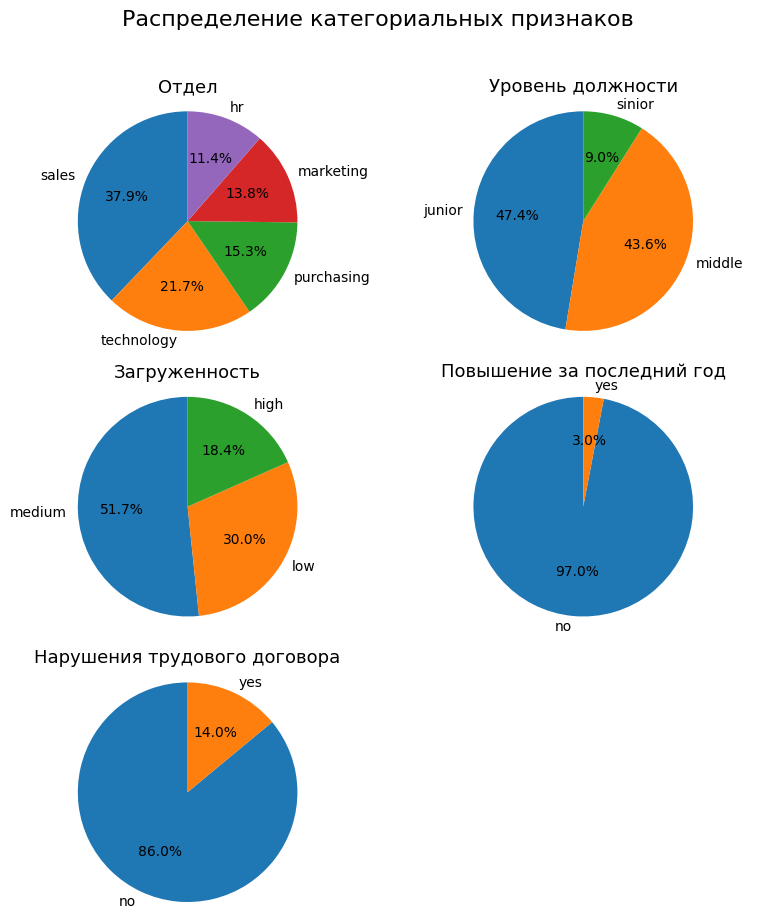

In [10]:
# задаем название графиков
col_titles = {
    'dept': 'Отдел',
    'level': 'Уровень должности',
    'workload': 'Загруженность',
    'last_year_promo': 'Повышение за последний год',
    'last_year_violations': 'Нарушения трудового договора'
}

cat_cols = list(col_titles.keys())

# задаем число строк и столбцов
n_cols = 2
n_rows = (len(cat_cols) + 1) // n_cols

# создаём фигуру
plt.figure(figsize=(8, n_rows * 3))
plt.suptitle('Распределение категориальных признаков', fontsize=16, y=1.02)

# цикл по признакам
for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    values = train_1.loc[train_1[col] != 'unknown', col].value_counts() # не будем учитывать значение "unknown" для чистоты графиков
    plt.pie(
        values,
        labels=values.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    plt.title(col_titles[col], fontsize=13)
    plt.axis('equal')

# выводим график
plt.tight_layout()
plt.show()

**Категориальные признаки:**

*   Большинство сотрудников работает в отделах sales (≈38%) и technology (≈22%);
*   По уровню должности преобладают junior (47%) и middle (44%);
*   Основная загруженность сотрудников — medium (≈52%), что указывает на равномерное распределение нагрузки;
*   Лишь 3% работников получили повышение за последний год;
*   Нарушения трудового договора редки — только 14% случаев.

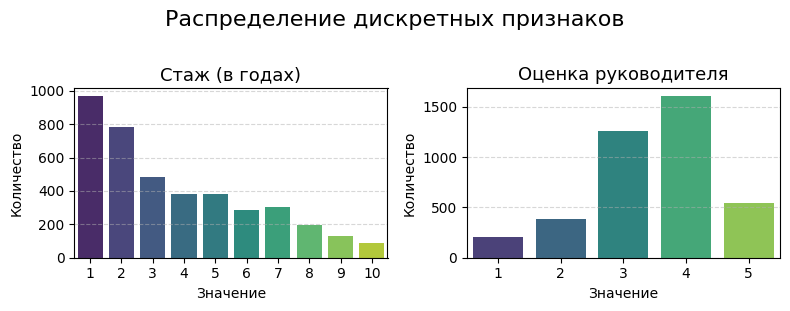

In [11]:
# задаем название
col_discrete_titles = {
    'employment_years': 'Стаж (в годах)',
    'supervisor_evaluation': 'Оценка руководителя'
}

# задаем число строк и столбцов
n_cols = 2
n_rows = (len(discrete_cols) + 1) // n_cols

# создаём фигуру
plt.figure(figsize=(8, n_rows * 3))
plt.suptitle('Распределение дискретных признаков', fontsize=16, y=1.02)

# цикл по признакам
for i, col in enumerate(discrete_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(
        data=train_1,
        x=col,
        palette='viridis'
    )
    plt.title(col_discrete_titles[col], fontsize=13)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

# выводим график
plt.tight_layout()
plt.show()

**Дискретные признаки:**

*   Большинство сотрудников имеет небольшой стаж (1–3 года), затем количество постепенно снижается.;
*   По уровню оценке руководителя распределение пиковое на 4 баллах (самая частая оценка), далее 3 балла, затем 5 баллов; 1–2 встречаются редко.


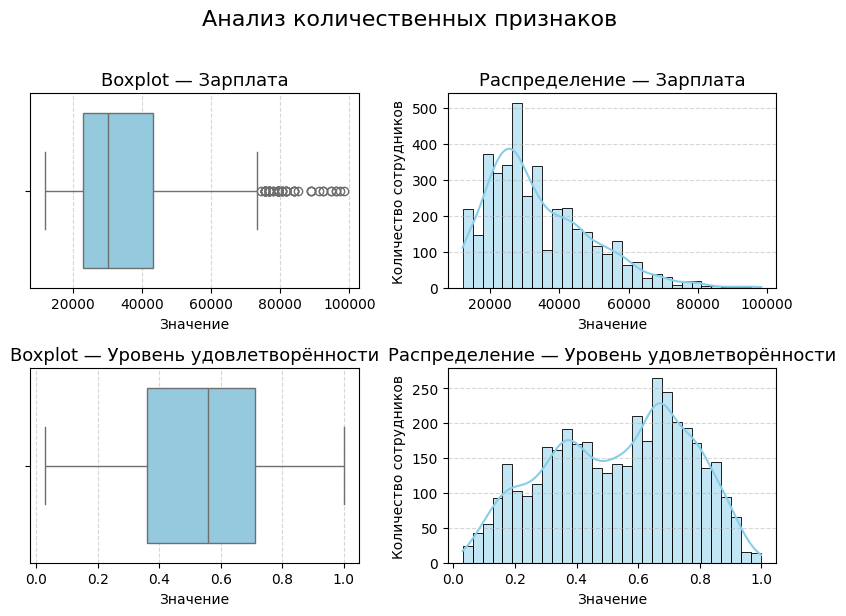

In [12]:
# задаем название
col_num_titles = {
    'salary': 'Зарплата',
    'job_satisfaction_rate': 'Уровень удовлетворённости'
}

# создаём фигуру
plt.figure(figsize=(8, len(num_cols) * 3))
plt.suptitle('Анализ количественных признаков', fontsize=16, y=1.02)

# цикл по признакам
for i, col in enumerate(num_cols, 1):
    # boxplot
    plt.subplot(len(num_cols), 2, 2*i - 1)
    sns.boxplot(
        data=train_1,
        x=col,
        color='skyblue'
    )
    plt.title(f'Boxplot — {col_num_titles[col]}', fontsize=13)
    plt.xlabel('Значение')
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # гистограмма
    plt.subplot(len(num_cols), 2, 2*i)
    sns.histplot(
        data=train_1,
        x=col,
        kde=True,
        bins=30,
        color='skyblue'
    )
    plt.title(f'Распределение — {col_num_titles[col]}', fontsize=13)
    plt.xlabel('Значение')
    plt.ylabel('Количество сотрудников')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

# выводим график
plt.tight_layout()
plt.show()


**Количественные признаки:**

*   Зарплата имеет широкий разброс и заметные выбросы вверх (до 100 000), распределение скошено вправо — основная часть сотрудников получает от 20 000 до 40 000;
*   Уровень удовлетворённости распределён относительно равномерно, но ближе к центру (0.4–0.7).


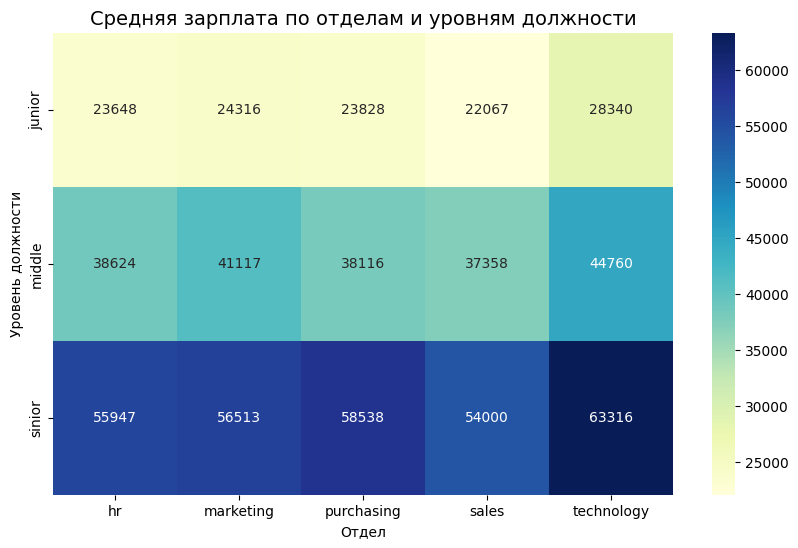

In [13]:
# найдем среднюю зарплату в зависимости от ключевых категориальных признаков

# не будем учитывать значения unknown
df_salary = train_1[
    (train_1['dept'] != 'unknown') &
    (train_1['level'] != 'unknown')
]

# создаём сводную таблицу
pivot_salary = df_salary.pivot_table(
    values='salary',
    index='level',
    columns='dept',
    aggfunc='mean'
)

# визуализация
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_salary,
    annot=True,
    fmt='.0f',
    cmap='YlGnBu'
)
plt.title('Средняя зарплата по отделам и уровням должности', fontsize=14)
plt.xlabel('Отдел')
plt.ylabel('Уровень должности')
plt.show()

**Вывод по heatmap:**
*   Зарплата закономерно растёт с должностным уровнем: senior → middle → junior;
*   Наиболее высокие зарплаты наблюдаются в отделе technology, минимальные — в sales и hr.



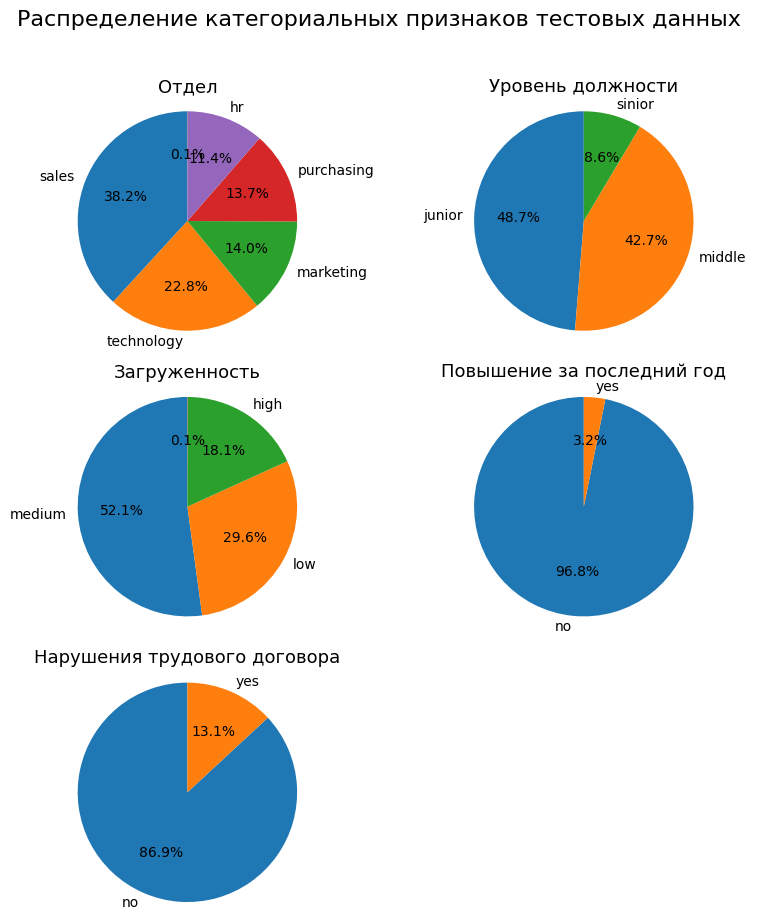

In [14]:
# задаем название графиков
col_titles = {
    'dept': 'Отдел',
    'level': 'Уровень должности',
    'workload': 'Загруженность',
    'last_year_promo': 'Повышение за последний год',
    'last_year_violations': 'Нарушения трудового договора'
}

cat_cols = list(col_titles.keys())

# задаем число строк и столбцов
n_cols = 2
n_rows = (len(cat_cols) + 1) // n_cols

# создаём фигуру
plt.figure(figsize=(8, n_rows * 3))
plt.suptitle('Распределение категориальных признаков тестовых данных', fontsize=16, y=1.02)

# цикл по признакам
for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    values = test_features.loc[test_features[col] != 'unknown', col].value_counts() # не будем учитывать значение "unknown" для чистоты графиков
    plt.pie(
        values,
        labels=values.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    plt.title(col_titles[col], fontsize=13)
    plt.axis('equal')

# выводим график
plt.tight_layout()
plt.show()

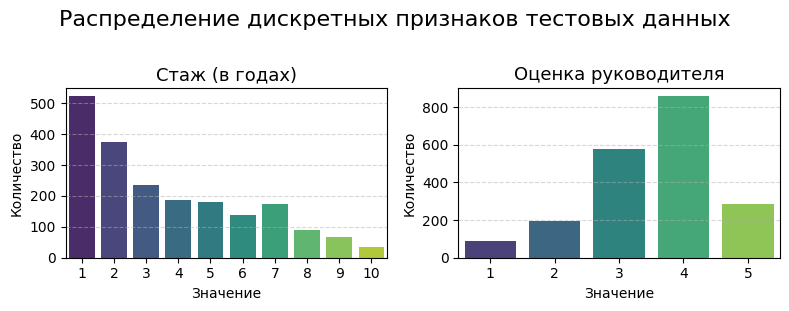

In [15]:
# задаем название
col_discrete_titles = {
    'employment_years': 'Стаж (в годах)',
    'supervisor_evaluation': 'Оценка руководителя'
}

# задаем число строк и столбцов
n_cols = 2
n_rows = (len(discrete_cols) + 1) // n_cols

# создаём фигуру
plt.figure(figsize=(8, n_rows * 3))
plt.suptitle('Распределение дискретных признаков тестовых данных', fontsize=16, y=1.02)

# цикл по признакам
for i, col in enumerate(discrete_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(
        data=test_features,
        x=col,
        palette='viridis'
    )
    plt.title(col_discrete_titles[col], fontsize=13)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

# выводим график
plt.tight_layout()
plt.show()

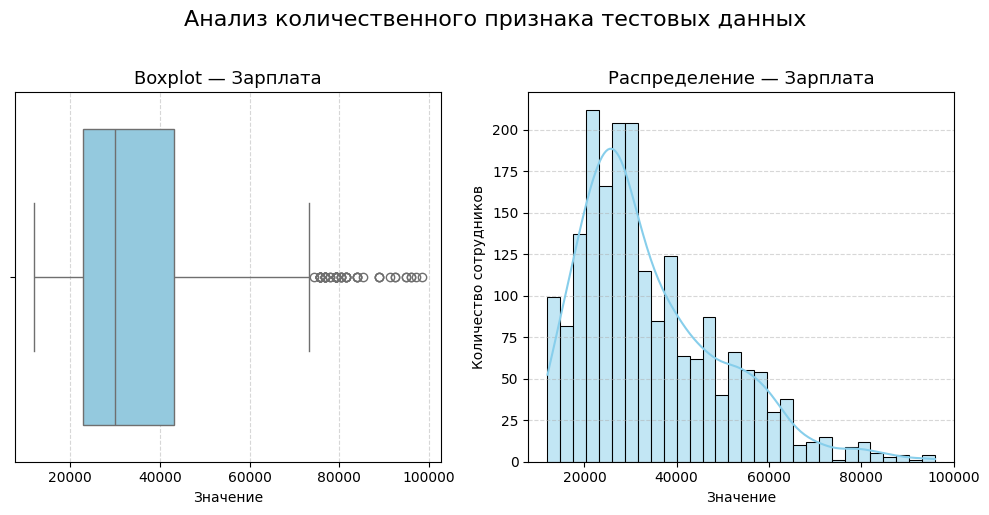

In [16]:
# задаем название
col_num_titles = {
    'salary': 'Зарплата'
}

# создаём фигуру )
plt.figure(figsize=(10, 5))
plt.suptitle('Анализ количественного признака тестовых данных', fontsize=16, y=1.02)

col = 'salary'

# boxplot
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, позиция 1
sns.boxplot(
    data=train_1,
    x=col,
    color='skyblue'
)
plt.title(f'Boxplot — {col_num_titles[col]}', fontsize=13)
plt.xlabel('Значение')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# гистограмма
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, позиция 2
sns.histplot(
    data=test_features,
    x=col,
    kde=True,
    bins=30,
    color='skyblue'
)
plt.title(f'Распределение — {col_num_titles[col]}', fontsize=13)
plt.xlabel('Значение')
plt.ylabel('Количество сотрудников')
plt.grid(axis='y', linestyle='--', alpha=0.5)

# выводим график
plt.tight_layout()
plt.show()

Сравнивая графики тренировочных и тестовых данных, можно сделать вывод, что они предельно похожи.

Распределение значений процентного соотношения категориальных признаков отличается не более чем на 2 %.

Распределение дискретных признаков имеет одинаковую структуру.

Boxplot и распределение зарплаты аналогичны друг другу.

Тренировочные и тестовые выборки отличаются лишь количеством наблюдений - 4000 и 2000 соответственно, а так же отсутствием во второй целевого признака - уровня удовлетворенности.

### Кореляционный анализ

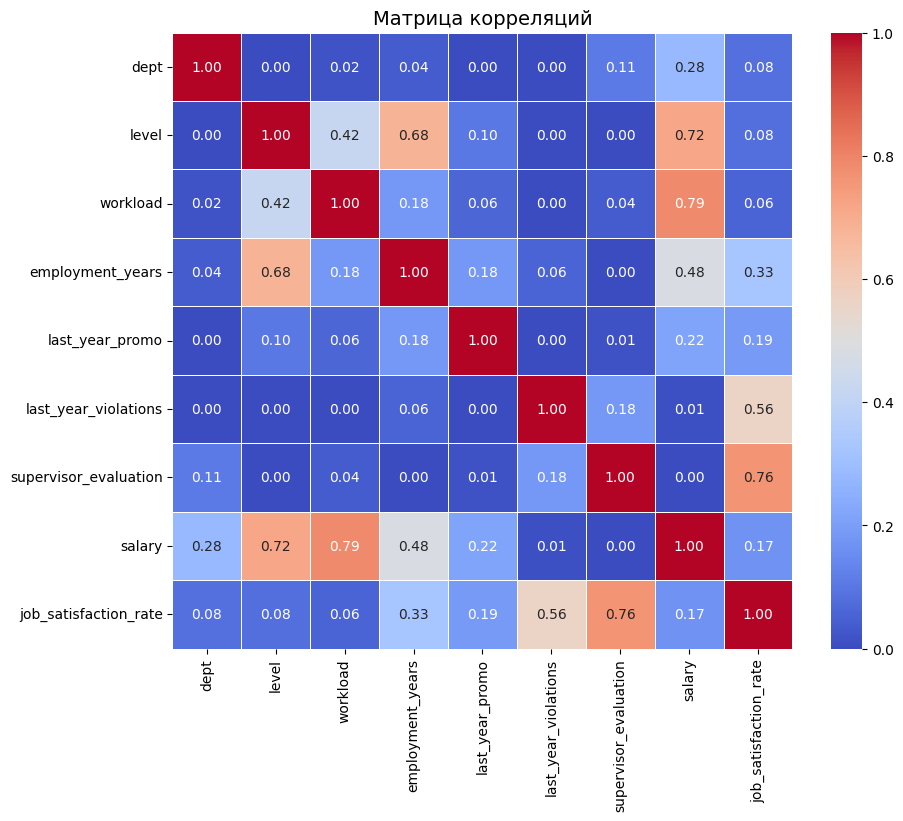

In [17]:
# список интервальных признаков
interval_cols = ['salary', 'job_satisfaction_rate']

# уберем столбец id
train_1_matrix = train_1.drop(columns=['id'], errors='ignore')

# считаем матрицу корреляций
phik_matrix = train_1_matrix.phik_matrix(interval_cols=interval_cols)

# визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Матрица корреляций', fontsize=14)
plt.show()

Корреляционный анализ показывает, что:
Целевой признак (удовлетворенность работой) имеет сильную зависимость от оценки руководителя (0.79), а так же зависимости от факта нарушения трудового договора сотрудником (0.59) и факта повышения в прошлом году (0.43).

Так же есть сильные зависимости между:


*   уровнем удовлетворенности и оценкой руководителя (0.76), уровнем удовлетворенности и нарушениями договора (0.56)
*   уровнем и стажа, уровнем и зарплатой (0.68 и 0.72 соответственно), а так же уровнем и загруженностью (0.42)
*   зарплаты и загруженностью (0.79), зарплаты и уровнем специалиста (0.72), зарплатой и стажем (0.48)

### Промежуточный вывод:
Провели классификацию колонок и определились с дальнейшей обработкой.

Провели графический анализ категориальных, дискретных и числовых признаков.

Нашли среднюю зарплату в зависимости от уровня специалиста и отдела, в котором он работает.

Провели корреляционный анализ.

## Подготовка данных

In [18]:
df = train_1.copy()

X = df.drop(columns=['id', 'job_satisfaction_rate'])
y = df['job_satisfaction_rate']

#X = X.replace('unknown', np.nan)

In [19]:
# списки признаков
nominal_cat_cols = ['dept']
ordinal_cat_cols = ['level', 'workload']
num_cols = ['employment_years', 'salary', 'supervisor_evaluation']
ord_binary_cols   = ['last_year_promo', 'last_year_violations']  # бинарные с порядком

for c in num_cols:
    X[c] = pd.to_numeric(X[c], errors='coerce')

# порядки для OrdinalEncoder
level_order = ['junior', 'middle', 'sinior']
workload_order = ['low', 'medium', 'high']

# порядки для бинарных
promo_order = ['no', 'yes']   # yes лучше
violations_order = ['yes', 'no']   # no лучше

# числовой пайплайн
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# порядковые
ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[level_order, workload_order],
        handle_unknown='use_encoded_value', unknown_value=-1
    ))
])

# порядковые бинарные
ord_binary_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[promo_order, violations_order],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

# номинативные
nom_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
])

# сборка препроцессора
preprocess = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('ord_true', ord_pipe, ordinal_cat_cols),
    ('ord_binary', ord_binary_pipe, ord_binary_cols),
    ('nom', nom_pipe, nominal_cat_cols),
], remainder='drop', verbose_feature_names_out=False)

### Промежуточный вывод:
Создали Пайплайн подготовки данных с элементами предобработки (SimpleImputer) с учетом особенностей признаков.

## Обучение моделей

### Создание функции

In [20]:
def smape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    denom = np.where(denom == 0, 1e-9, denom)  # защита от деления на 0
    return np.mean(np.abs(y_true - y_pred) / denom) * 100

In [21]:
# создаем scorer
smape_scorer = make_scorer(smape, greater_is_better=False)

In [22]:
# кросс валидация
cv = KFold(n_splits=10, shuffle=True, random_state=42)

### Создание PipeLine

In [23]:
# общий пайплайн
pipe = Pipeline([
    ('preprocess', preprocess),
    ('model', LinearRegression())
])

In [62]:
RANDOM_STATE = 42

param_grid = [
    {   # LinearRegression
        'model': [LinearRegression()],
        'preprocess__num__scaler': [StandardScaler(), MinMaxScaler()],
    },
    {   # DecisionTreeRegressor
        'model': [DecisionTreeRegressor(random_state=42)],
        'preprocess__num__scaler': [StandardScaler(), MinMaxScaler()],
        'model__max_depth': [5, 6, 7, 8, 9, 10, 12],
        'model__min_samples_leaf': [1, 2, 4, 6, 8],
        'model__min_samples_split': [2, 4, 6, 8, 10, 12],
        'model__criterion': ['friedman_mse', 'squared_error']
    }
]

### Поиск лучшей модели

In [25]:
[param for d in param_grid for param in d.keys()]

['model',
 'preprocess__num__scaler',
 'model',
 'preprocess__num__scaler',
 'model__max_depth',
 'model__min_samples_leaf',
 'model__min_samples_split',
 'model__criterion']

In [63]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=smape_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)

Fitting 10 folds for each of 842 candidates, totalling 8420 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'model': [LinearRegression()], 'preprocess__num__scaler': [StandardScaler(), MinMaxScaler()]}, {'model': [DecisionTreeR...ndom_state=42)], 'model__criterion': ['friedman_mse', 'squared_error'], 'model__max_depth': [5, 6, ...], 'model__min_samples_leaf': [1, 2, ...], ...}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",make_scorer(s...hod='predict')
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default va

In [27]:
# Объединяем по id
test_full = test_features.merge(test_rate, on='id', how='inner')

# Исправим как в учебном дф
#test_full['level'] = test_full['level'].replace('sinior', 'senior')

# Теперь делим
X_test = test_full.drop(columns=['id', 'job_satisfaction_rate'])
y_test = test_full['job_satisfaction_rate']

### Предсказание

In [28]:
y_pred = grid.best_estimator_.predict(X_test)
test_smape = smape(y_test, y_pred)
print(f"SMAPE на тесте: {test_smape:.2f}")

SMAPE на тесте: 15.18


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


### Важность признаков

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


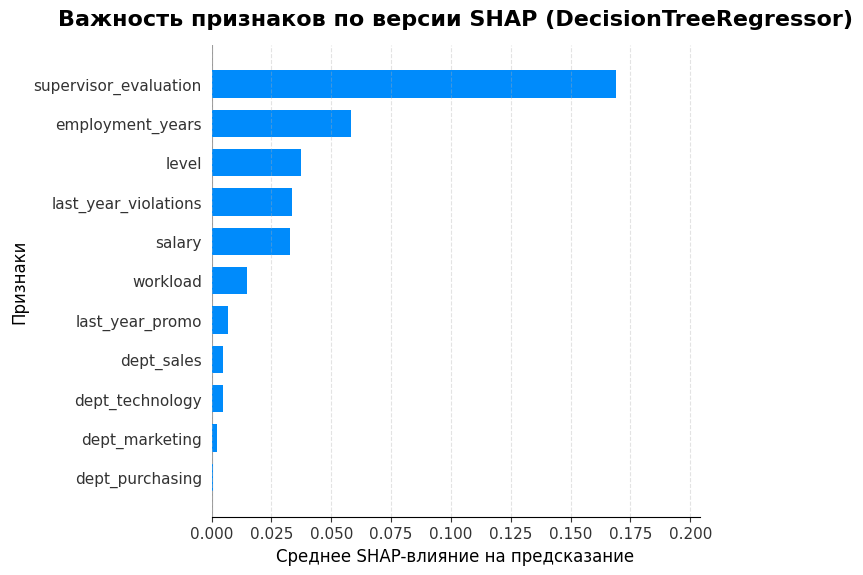

In [29]:
best_model = grid.best_estimator_

# достаём шаги из пайплайна и трансформим данные
prep  = best_model.named_steps['preprocess']
model = best_model.named_steps['model']

Xtr = prep.transform(X)
Xte = prep.transform(X_test)

feat_names = prep.get_feature_names_out()

# SHAP для дерева
explainer = shap.TreeExplainer(model)
shap_values = explainer(Xte)

# важности по SHAP
plt.figure(figsize=(16, 9))
shap.summary_plot(
    shap_values,
    Xte,
    feature_names=feat_names,
    plot_type='bar',
    show=False,
    max_display=20
)

ax = plt.gca()
plt.subplots_adjust(left=0.35, right=0.96, top=0.90, bottom=0.10)
ax.set_title('Важность признаков по версии SHAP (DecisionTreeRegressor)', fontsize=16, fontweight='bold', pad=14)
ax.set_xlabel('Среднее SHAP-влияние на предсказание', fontsize=12)
ax.set_ylabel('Признаки', fontsize=12)
ax.grid(axis='x', linestyle='--', alpha=0.35)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# расширим ось X
x0, x1 = ax.get_xlim()
ax.set_xlim(0, x1 * 1.15)

plt.show()

### Сравнение с константой

In [30]:
median_pred = np.full_like(y_test, np.median(y))
print(f"SMAPE baseline = {smape(y_test, median_pred):.2f}")
print(f"SMAPE лучшей модели: {test_smape:.2f}")

SMAPE baseline = 37.55
SMAPE лучшей модели: 15.18


### Промежуточный вывод

Для прогнозирования уровня удовлетворённости сотрудников был собран Pipeline для преодобработки данных и поиска лучшей модели.


---


Лучшей моделью оказалась DecisionTreeRegressor со следующими параметрами:
*   max_depth = 9;
*   min_samples_split = 2;
*   min_samples_leaf = 4;


---


Для улучшения качества были протестированы параметры глубины дерева, минимального числа объектов в узлах, критерия разбиения и типа масштабирования числовых признаков.


---


SMAPE лучшей модели составил 15.18.


---


Так же был проведён анализ важности признаков с помощью SHAP-значений, который показал, что наибольшее влияние на прогноз оказывают:
*   оценка руководителя;
*   стаж сотрудника;
*   уровень сотрудника;
*   количество фактов нарушения сотрудником трудового договора;
*   зарплата.










## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных
Загрузка данных осуществлена одновременно с данными для первой задачи.

### Предобработка данных
Дубликаты и пропуска отсутствуют. Анализ выполнен в первой части.

### Исследовательский анализ данных

In [31]:
# quit - увольнение сотрудника из компании
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [32]:
# исправим значение
#train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

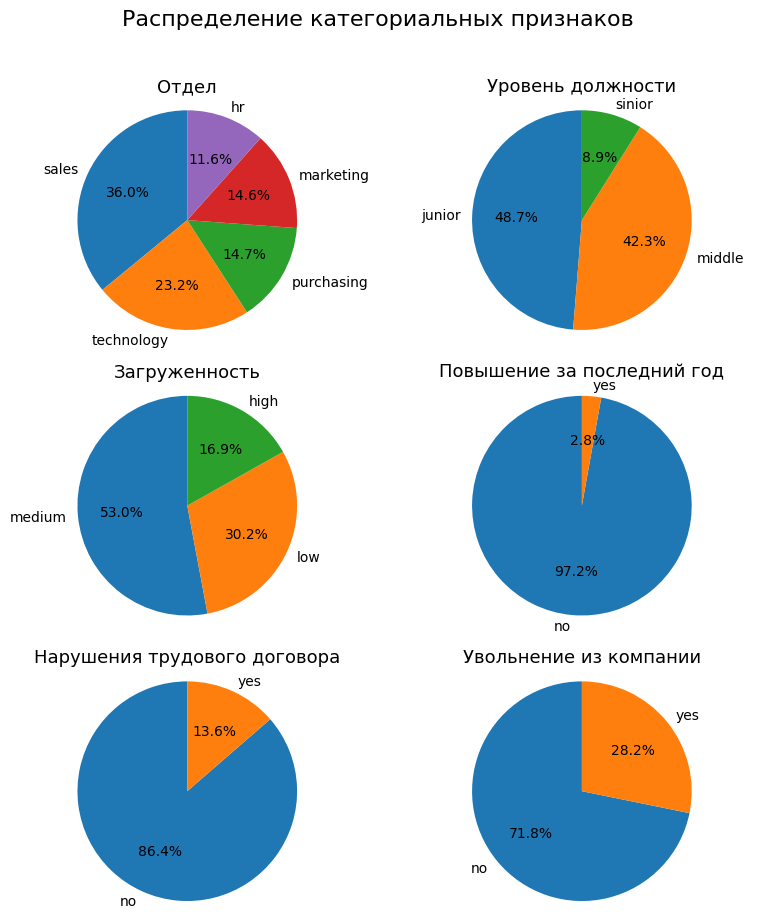

In [33]:
# задаём подписи для графиков
col_titles = {
    'dept': 'Отдел',
    'level': 'Уровень должности',
    'workload': 'Загруженность',
    'last_year_promo': 'Повышение за последний год',
    'last_year_violations': 'Нарушения трудового договора',
    'quit': 'Увольнение из компании'
}

cat_cols = list(col_titles.keys())

# задаём число строк и столбцов
n_cols = 2
n_rows = (len(cat_cols) + 1) // n_cols

# создаем фигуру
plt.figure(figsize=(8, n_rows * 3))
plt.suptitle('Распределение категориальных признаков', fontsize=16, y=1.02)

# цикл по признакам
for i, col in enumerate(cat_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    # исключаем "unknown"
    values = train_quit.loc[train_quit[col] != 'unknown', col].value_counts()

    plt.pie(
        values,
        labels=values.index,
        autopct='%1.1f%%',
        startangle=90,
        textprops={'fontsize': 10}
    )
    plt.title(col_titles[col], fontsize=13)
    plt.axis('equal')

# выводим график
plt.tight_layout()
plt.show()

Отдел: больше всего сотрудников работает в sales (36%) и technology (23%), меньше всего — в hr (12%).

Уровень должности: почти половина сотрудников — junior (49%), middle — 42%, senior — 9%.

Загруженность: преобладает medium уровень нагрузки (53%), у 17% нагрузка высокая.

Повышение за последний год: только 2.8% сотрудников получали повышение.

Нарушения трудового договора: нарушения встречаются в 13.6% случаях.

Увольнение из компании: 28.2% сотрудников покинули компанию, 71.8% остались.

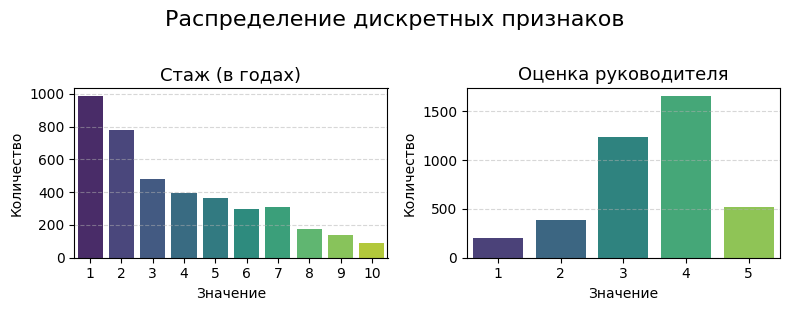

In [34]:
# задаем название
col_discrete_titles = {
    'employment_years': 'Стаж (в годах)',
    'supervisor_evaluation': 'Оценка руководителя'
}

# задаем число строк и столбцов
n_cols = 2
n_rows = (len(discrete_cols) + 1) // n_cols

# создаём фигуру
plt.figure(figsize=(8, n_rows * 3))
plt.suptitle('Распределение дискретных признаков', fontsize=16, y=1.02)

# цикл по признакам
for i, col in enumerate(discrete_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(
        data=train_quit,
        x=col,
        palette='viridis'
    )
    plt.title(col_discrete_titles[col], fontsize=13)
    plt.xlabel('Значение')
    plt.ylabel('Количество')
    plt.grid(axis='y', linestyle='--', alpha=0.5)

# выводим график
plt.tight_layout()
plt.show()

**Дискретные признаки:**

*   Большинство сотрудников имеет небольшой стаж (1–2 года), количество сотрудников со стажем от 2 до 5 лет примерно одинаковое, сотрудников со стажем 7 лет больше, чем сотрудников со стажем 6 лет, после отметки 7 лет - с каждым годом стажа количество постепенно снижается.
*   По уровню оценке руководителя распределение пиковое на 4 баллах (самая частая оценка), далее 3 балла, затем 5 баллов и 2 балла имеют примерно одинаковое значение, 1 балл ставят реже всего.

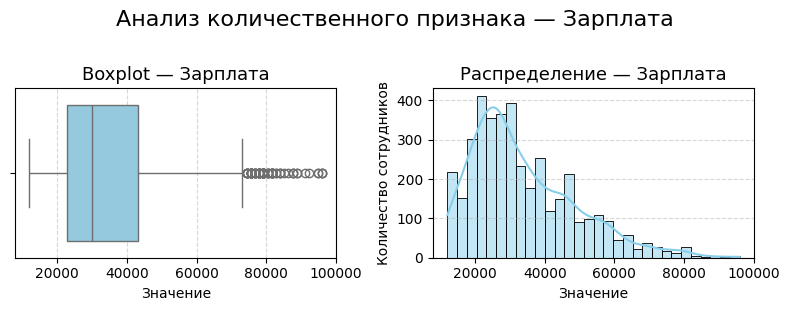

In [35]:
plt.figure(figsize=(8, 3))
plt.suptitle('Анализ количественного признака — Зарплата', fontsize=16, y=1.02)

# boxplot
plt.subplot(1, 2, 1)
sns.boxplot(
    data=train_quit,
    x='salary',
    color='skyblue'
)
plt.title('Boxplot — Зарплата', fontsize=13)
plt.xlabel('Значение')
plt.grid(axis='x', linestyle='--', alpha=0.5)

# гистограмма
plt.subplot(1, 2, 2)
sns.histplot(
    data=train_quit,
    x='salary',
    kde=True,
    bins=30,
    color='skyblue'
)
plt.title('Распределение — Зарплата', fontsize=13)
plt.xlabel('Значение')
plt.ylabel('Количество сотрудников')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Зарплаты распределены асимметрично — большинство сотрудников получают до 40 000 , но есть отдельные выбросы с зарплатой выше 80 000.

Медиана находится на уровне 30 000 ₽.

In [36]:
# Список категориальных признаков
cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

# Группируем по целевому признаку и считаем долю каждой категории
for col in cat_cols:
    cross = (
        train_quit.groupby(['quit', col])
        .size()
        .groupby(level=0)
        .apply(lambda x: round(100 * x / x.sum(), 1))
        .unstack(fill_value=0)
    )
    print(f"\nРаспределение по признаку: {col}")
    display(cross)


Распределение по признаку: dept


,dept,hr,marketing,purchasing,sales,technology
quit,quit,,,,,
no,no,12.1,14.6,14.7,35.9,22.7
yes,yes,10.3,14.5,14.7,36.1,24.5



Распределение по признаку: level


,level,junior,middle,sinior
quit,quit,,,
no,no,32.9,55.2,11.8
yes,yes,88.9,9.6,1.5



Распределение по признаку: workload


,workload,high,low,medium
quit,quit,,,
no,no,19.3,24.0,56.8
yes,yes,10.7,46.0,43.3



Распределение по признаку: last_year_promo


,last_year_promo,no,yes
quit,quit,,
no,no,96.1,3.9
yes,yes,99.9,0.1



Распределение по признаку: last_year_violations


,last_year_violations,no,yes
quit,quit,,
no,no,89.0,11.0
yes,yes,79.8,20.2


Портрет уволившегося сотрудника:
*   чаще других увольняются сотрудники из отдела sales и technology (36% и 24.5% соответственно);
*   89% уволившихся сотрудников - junior специалисты ;
*   люди с высокой загрузкой реже увольняются (10.7%) по сравнению с сотрудниками с низкой и средней загруженностью (46% и 43% соответственно);
*   почти в 100 % случаях уволившийся сотрудник не получал повышения в прошлом году;
*   нарушения трудового договора со стороны сотрудника не сильно влияет на его увольнение, 80% уволившихся сотрудников договор не нарушали.




In [37]:
salary_stats = (
    train_quit.groupby('quit')['salary']
    .agg(['count','mean','median','std','min','max'])
    .round(2)
    .rename(columns={
        'count':'количество',
        'mean':'средняя_зарплата',
        'median':'медианная_зарплата',
        'std':'стандартное отклонение',
        'min':'минимум',
        'max':'максимум'
    })
)
salary_stats

,количество,средняя_зарплата,медианная_зарплата,стандартное отклонение,минимум,максимум
quit,,,,,,
no,2872,37702.23,34800.0,15218.98,12000,96000
yes,1128,23885.11,22800.0,9351.60,12000,79200


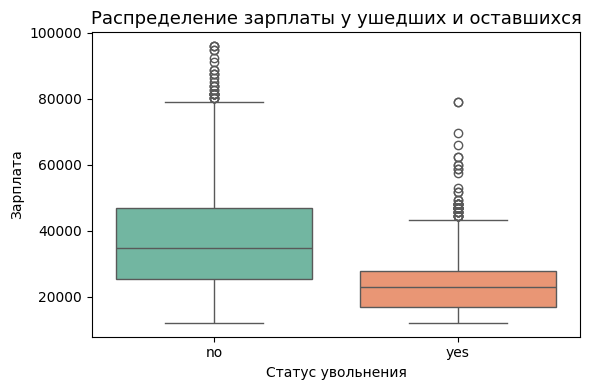

In [38]:
plt.figure(figsize=(6,4))
sns.boxplot(data=train_quit, x='quit', y='salary', palette='Set2')
plt.title('Распределение зарплаты у ушедших и оставшихся', fontsize=13)
plt.xlabel('Статус увольнения')
plt.ylabel('Зарплата')
plt.tight_layout()
plt.show()

Графики boxplot наглядно показывают разницу в зарплате между уволившимися сотрудниками и теми, кто остался на работе.

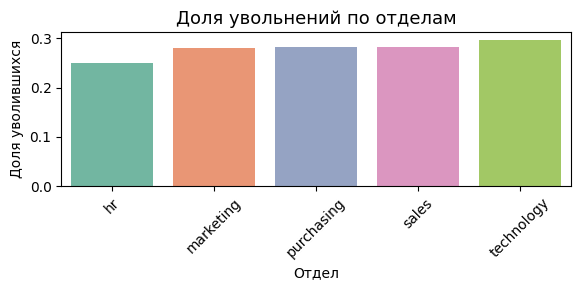

In [39]:
plot_data = train_quit.groupby('dept')['quit'].apply(
    lambda x: (x == 'yes').mean()
).reset_index()

plt.figure(figsize=(6, 3))
sns.barplot(data=plot_data, x='dept', y='quit', palette='Set2')
plt.title('Доля увольнений по отделам', fontsize=13)
plt.ylabel('Доля уволившихся')
plt.xlabel('Отдел')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Доля увольнений для разных отделов практически одинаково, меньше всего уволившихся сотрудников работали в отделе hr.

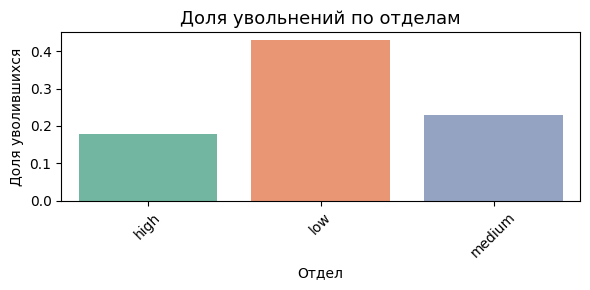

In [40]:
plot_data = train_quit.groupby('workload')['quit'].apply(
    lambda x: (x == 'yes').mean()
).reset_index()

plt.figure(figsize=(6, 3))
sns.barplot(data=plot_data, x='workload', y='quit', palette='Set2')
plt.title('Доля увольнений по отделам', fontsize=13)
plt.ylabel('Доля уволившихся')
plt.xlabel('Отдел')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Чем выше загруженность сотруника - тем меньше шансов того, что он уволится.

### Зависимость увольнения от уровня удовлетворенности


In [41]:
# объединяем по id
test_merged = pd.merge(test_quit, test_rate, on='id')

In [42]:
# считаем среднюю удовлетворённость для каждой группы
mean_values = test_merged.groupby('quit')['job_satisfaction_rate'].mean().round(3)
print("Средние значения удовлетворённости:")
print(mean_values)

Средние значения удовлетворённости:
quit
no     0.612
yes    0.388
Name: job_satisfaction_rate, dtype: float64


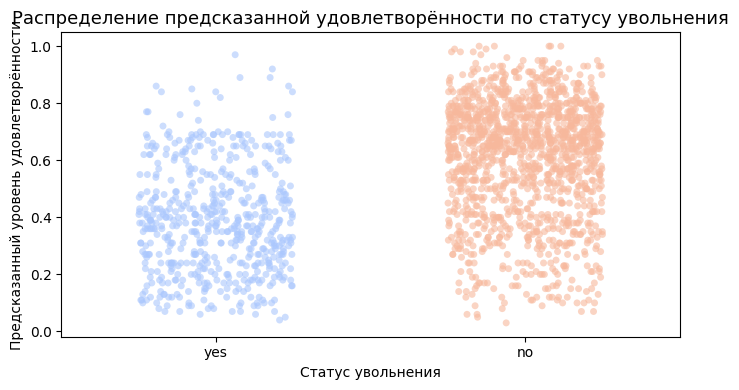

In [43]:
plt.figure(figsize=(7,4))
sns.stripplot(
    data=test_merged,
    x='quit',
    y='job_satisfaction_rate',
    jitter=0.25,
    alpha=0.6,
    palette='coolwarm'
)
plt.title('Распределение предсказанной удовлетворённости по статусу увольнения', fontsize=13)
plt.xlabel('Статус увольнения')
plt.ylabel('Предсказанный уровень удовлетворённости')
plt.tight_layout()
plt.show()

Табличные данные и график наглядно показывают, что теория аналитиков, что увровень удовлетворенности влияет на увольнения верна.

Средний уровень уволившихся - 0.388, а тех, кто остался на работе - 0.612.

Так же по графику видно, что если уровень удовлетворенности больше 0.7 - намного вероятнее, что сотрудник останется на рабочем месте.

In [44]:
# выделим группы
group_no = test_merged.loc[test_merged['quit'] == 'no', 'job_satisfaction_rate']
group_yes = test_merged.loc[test_merged['quit'] == 'yes', 'job_satisfaction_rate']

# t-test
t_stat, p_val = ttest_ind(group_no, group_yes, equal_var=False)
print(f"t-статистика = {t_stat:.3f}, p-value = {p_val:.5f}")

# результат
if p_val < 0.05:
    print("Различие между группами статистически значимо")
else:
    print("Статистически значимых различий нет")

t-статистика = 23.795, p-value = 0.00000
Различие между группами статистически значимо


Статистический тест показал, что различие между группами «уволился» и «остался» статистически значимо.
Средний уровень удовлетворённости сотрудников, которые остались в компании (0.61), выше, чем у уволившихся (0.39).
Это подтверждает гипотезу о связи удовлетворённости с вероятностью увольнения.

### Добавление нового входного признака

In [45]:
# сделаем копию дф
df_pred = test_features.copy()

# добавим новый столбец, в который запишем предсказанные лучшей моделью значения уровня удовлетворенности
df_pred['job_satisfaction_rate'] = best_model.predict(df_pred)

# заменим значение на правильное
#df_pred['level'] = df_pred['level'].replace('sinior', 'senior')

#df_pred = clean_all_cells(df_pred)

# убедимся
df_pred.head()

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,485046,marketing,junior,medium,2,no,no,5,28800,0.832442
1,686555,hr,junior,medium,1,no,no,4,30000,0.640826
2,467458,sales,middle,low,5,no,no,4,19200,0.656111
3,418655,sales,middle,low,6,no,no,4,19200,0.656111
4,789145,hr,middle,medium,5,no,no,5,40800,0.791140


In [46]:
# для тренировочной выборки (train_quit)
train_quit = train_quit.copy()
train_quit['job_satisfaction_rate'] = best_model.predict(train_quit)

# убедимся
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
0,723290,sales,middle,high,2,no,no,4,54000,no,0.623721
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.832442
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.415882
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.340000
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.809184


Предсказанный уровень удовлетворенности успешно добавлен.

# Корреляционный анализ

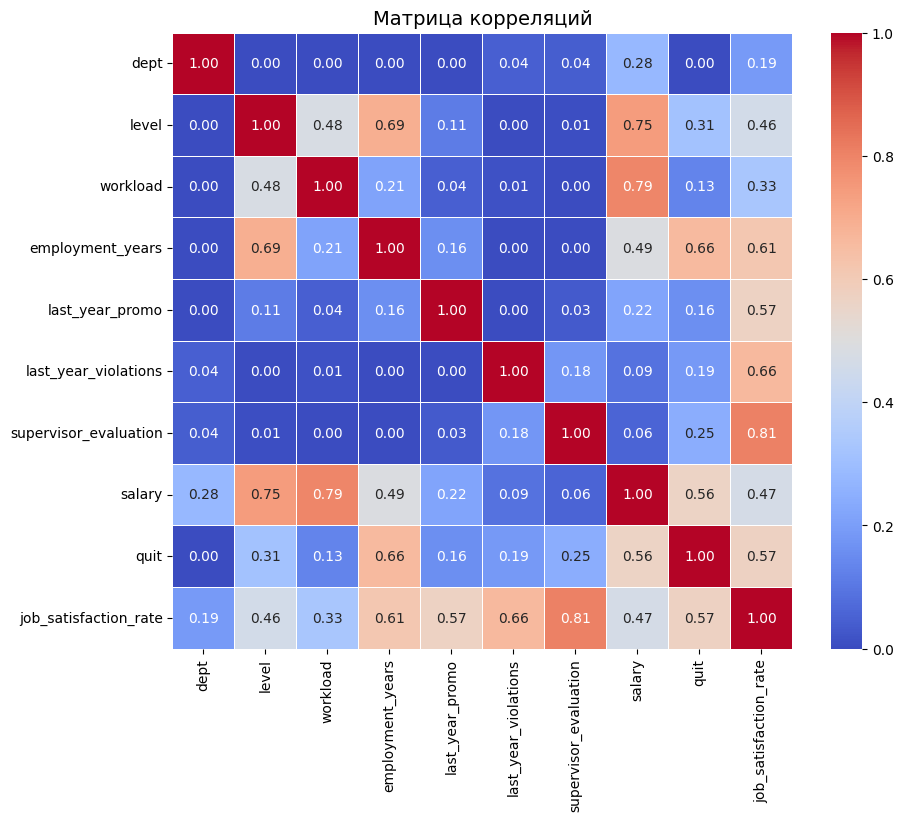

In [47]:
# список интервальных признаков
interval_cols = ['salary', 'job_satisfaction_rate']

# уберем столбец id
train_quit_matrix = train_quit.drop(columns=['id'], errors='ignore')

# считаем матрицу корреляций
phik_matrix = train_quit_matrix.phik_matrix(interval_cols=interval_cols)

# визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Матрица корреляций', fontsize=14)
plt.show()

Ключевые моменты:

*   Зарплата наиболее сильно зависит от нагрузки и уровня должности;
*   Удовлетворенность работой тесно связана с оценкой руководителя и отсутствием нарушений
*   Стаж работы коррелирует с уровнем должности и удовлетворенностью
*   Текучесть кадров связана со стажем, зарплатой и уровнем удовлетворенности



### Подготовка данных

In [48]:
df2 = train_quit.copy()

X2 = df2.drop(columns=['id', 'quit'])
y2 = df2['quit']

#X2 = clean_all_cells(X2)

In [49]:
# списки признаков
nominal_cat_cols = ['dept']
ordinal_cat_cols = ['level', 'workload']
ord_binary_cols  = ['last_year_promo', 'last_year_violations']
num_cols = ['employment_years', 'salary', 'supervisor_evaluation', 'job_satisfaction_rate']

# порядки для OrdinalEncoder
level_order    = ['junior', 'middle', 'sinior']
workload_order = ['low', 'medium', 'high']
promo_order        = ['no', 'yes']   # "yes" лучше
violations_order   = ['yes', 'no']   # "no" лучше

# числовые признаки
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# категориальные порядковые
ord_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[level_order, workload_order],
        handle_unknown='use_encoded_value', unknown_value=-1
    ))
])

# порядковые бинарные
ord_binary_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[promo_order, violations_order],
        handle_unknown='use_encoded_value', unknown_value=-1
    ))
])

# категориаальные

nom_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'))
    ])

# предобработка
preprocess2 = ColumnTransformer([
        ('num', num_pipe, num_cols),
        ('ord_true', ord_pipe, ordinal_cat_cols),
        ('ord_binary', ord_binary_pipe, ord_binary_cols),
        ('nom', nom_pipe, nominal_cat_cols),
    ],
    remainder='drop',
    verbose_feature_names_out=False
)

### Обучение модели

In [50]:
# общий пайплайн
pipe2 = Pipeline([
    ('preprocess', preprocess2),
    ('model', LogisticRegression())
])

In [51]:
# кросс-валидация
cv2 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [52]:
param_grid2 = [

    # Logistic Regression
    {
        'model': [LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear')],
        'preprocess__num__scaler': [StandardScaler(), MinMaxScaler()],
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.1, 0.3, 1.0, 3.0, 10.0],
    },

    # KNN
    {
        'model': [KNeighborsClassifier()],
        'preprocess__num__scaler': [StandardScaler(), MinMaxScaler()],
        'model__n_neighbors': [3, 5, 7, 11, 15],
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2],
    },

    # SVC (RBF kernel)
    {
        'model': [SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42)],
        'preprocess__num__scaler': [StandardScaler(), MinMaxScaler()],
        'model__C': [0.5, 1, 3, 10],
        'model__gamma': ['scale', 'auto'],
    },

    # decision Tree
    {
        'model': [DecisionTreeClassifier(random_state=42, class_weight='balanced')],
        'preprocess__num__scaler': ['passthrough'],
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [None, 5, 8, 12, 16],
        'model__min_samples_split': [2, 5, 10, 20],
        'model__min_samples_leaf': [1, 2, 4, 8],
        'model__max_features': [None, 'sqrt', 'log2']
    }
]

In [53]:
# поиск по сетке
gs2 = GridSearchCV(
    estimator=pipe2,
    param_grid=param_grid2,
    scoring='roc_auc',
    cv=cv2,
    n_jobs=-1,
    refit=True,
    return_train_score=False
)

In [54]:
# обучение
gs2.fit(X2, y2)

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'model': [LogisticRegre...r='liblinear')], 'model__C': [0.1, 0.3, ...], 'model__penalty': ['l1', 'l2'], 'preprocess__num__scaler': [StandardScaler(), MinMaxScaler()]}, {'model': [KNeighborsClassifier()], 'model__n_neighbors': [3, 5, ...], 'model__p': [1, 2], 'model__weights': ['uniform', 'distance'], ...}, ...]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.2

In [55]:
# на тренировочных данных
best_model_quit = gs2.best_estimator_
print("Лучшая конфигурация:\n", gs2.best_params_)
print(f"ROC-AUC (TRAIN): {gs2.best_score_:.4f}")

Лучшая конфигурация:
 {'model': SVC(class_weight='balanced', probability=True, random_state=42), 'model__C': 10, 'model__gamma': 'auto', 'preprocess__num__scaler': MinMaxScaler()}
ROC-AUC (TRAIN): 0.9322


In [56]:
# чтобы избежать несоответствия id при расчете метрики
test_join = pd.merge(test_quit, df_pred, on='id', how='inner')

In [57]:
# делим объединенный дф
y_true = (test_join['quit'] == 'yes').astype(int)
X_test = test_join.drop(columns=['quit', 'id'], errors='ignore')

In [58]:
# предсказание принадлежности к классу 'yes'
y_proba = best_model_quit.predict_proba(X_test)[:, 1]

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


In [59]:
# расчет метрики для тестовых данных
roc = roc_auc_score(y_true, y_proba)
print(f"\nROC-AUC (TEST): {roc:.4f}")


ROC-AUC (TEST): 0.9237


In [60]:
# проверка модели на адекватность
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_test, y_true)
y_dummy_proba = dummy.predict_proba(X_test)[:, 1]
roc_baseline = roc_auc_score(y_true, y_dummy_proba)
roc_model = roc_auc_score(y_true, best_model_quit.predict_proba(X_test)[:, 1])
print(f"ROC-AUC baseline (константная модель): {roc_baseline:.4f}")

/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


ROC-AUC baseline (константная модель): 0.5000


Константная модель показала ROC-AUC 0.5,
что соответствует случайным предсказаниям.
Разработанная модель достигает ROC-AUC = 0.92,
что значительно превосходит базовый уровень и подтверждает её адекватность.

  0%|          | 0/150 [00:00<?, ?it/s]

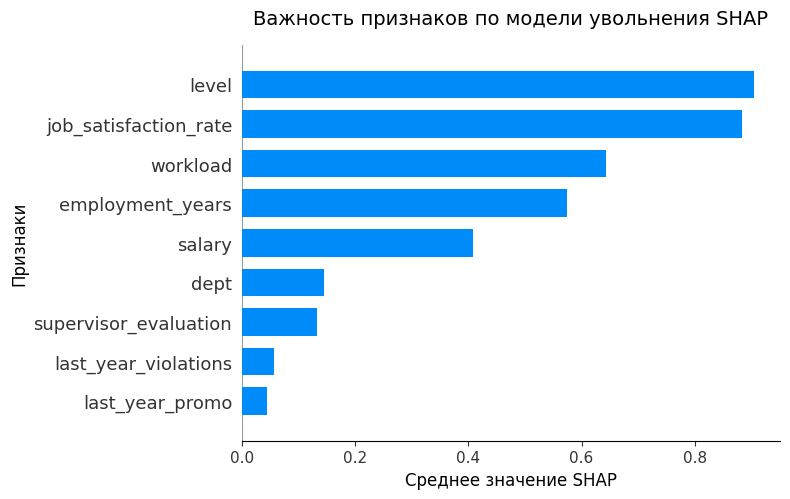

In [61]:
X_all = X2.copy()
def f_predict(X):
    X_df = pd.DataFrame(X, columns=X_all.columns)
    return best_model_quit.predict_proba(X_df)[:, 1]
bg_size = min(50, len(X_all))
ev_size = min(150, len(X_all))
background = X_all.sample(bg_size, random_state=42)
X_eval    = X_all.sample(ev_size, random_state=7)
explainer = shap.KernelExplainer(f_predict, background, link="logit")
shap_values = explainer.shap_values(X_eval, nsamples=50)
shap.summary_plot(
    shap_values,
    X_eval,
    feature_names=X_all.columns,
    plot_type='bar',
    max_display=15,
    show=False
)

# добавляем подписи
plt.title("Важность признаков по модели увольнения SHAP", fontsize=14, pad=15)
plt.xlabel("Среднее значение SHAP", fontsize=12)
plt.ylabel("Признаки", fontsize=12)
plt.tight_layout()
plt.show()

Ключевые выводы:

*   Уровень должности - главный фактор риска увольнения
*   Удовлетворенность работой - критически важна для удержания сотрудников
*   Нагрузка - существенно влияет на решение об уходе
*   Стаж и зарплата - имеют среднее влияние

### Выводы

Во второй задаче классификации лучше всех справилась модель SVC с параметрами (class_weight='balanced', probability=True, random_state=42), 'model__C': 10, 'model__gamma': 'auto', 'preprocess__num__scaler': MinMaxScaler().

Данная модель хорошо улавливает нелинейные связи, которые определенно присутствуют в нашей задаче.

Метрика ROC-AUC на тестовых данных составила 0.92.


## Общий вывод


В данном проекте мы решали по задаче руководства 2 задачи: **задачу регрессии** и **задачу классификации**.

---
В **задаче регрессии** нам было необходимо создать модель, которая предсказывала уровень удовлетворенности сотрудника (job_satisfaction_rate), саму модель мы оценивали по созданной нами метрике SMAPE, которая составила 15.37 на тестовых данных.

Лучшей моделью оказалась DecisionTreeRegressor с параметрами :max_depth=9, min_samples_leaf=2, min_samples_split=4, random_state=42.

---
Во второй задаче, необходимо было предсказать увольнение сотрудника - **задача классификации**, где целевой признак имел 2 параметра - да или нет.

После проверки гипотезы аналитиков о том, что уровень удовлетворенности влияет на то, уволится ли сотрудник, мы убедились в том, что эти параметры действительно связаны. Сотрудники с высоким уровнем удовлетворенности меньше подверждену увольнению.

С помощью нашей лучшей модели из 1 задачи мы предсказали значения уровня удовлетворенности для обучающих и тестовых данных второй задачи, и использовали их для обучения модели.

Лучшей моделью в задаче классификации является SVC с параметрами:class_weight='balanced', probability=True, random_state=42, 'model__C': 10, 'model__gamma': 'auto', 'preprocess__num__scaler': MinMaxScaler().

---
Перед тем как перейти к выполнению основных этапов проекта, мы проделали следующие шаги:
1.   загрузили данные с параметрами для их правильного отображения;
2.   проверили данные на наличие пропусков и полных дубликатов;
1.   провели исследовательский анализ тренировочных данных, включающий  в себя графических анализ категориальных, дискретных и числовых признаков;
2.   провели корреляционный анализ и нашли параметры, которые сильнее всего влияют на целевую переменную, а так же другие сильные связи;
1.   создали pipeline предобработки данных с учетом входных признаков модели;
1.   создали pipeline для модели, в котором использовали модель DecisionTreeRegressor с подбором гиперпараметров и LinearRegression;
2.   задали параметры кросс-валидации и с помощью поиска по сетке нашли лучшую модель, описанную выше;
1.   для данных второй задачи мы провели аналогичные исследования;
2.   искали лучшую модель среди 4: логической регрессии, KNN, SVC и дерева решений, лучшая модель описана выше;
2.   важным моментом при работе модели на тестовых данных стал факт того, что сначала надо соединить входные и целевой признак в общий датафрейм, а после этого делить их снова, т.к. если этого не сделать - метрики показывают существенно меньшие значения из-за несоответствия порядку идентификатора пользователя.

